## MH2 Unsupervised clustering

Trying to replicate results of unsupervised clustering for Supernova Hunters with the MuonHunters2 data.

In [25]:
%matplotlib inline
import os
import pickle
from dec_keras import DEC
import matplotlib.pyplot as plt
import numpy as np
import pandas
from collections import OrderedDict

from sklearn.decomposition import PCA
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

from keras.optimizers import SGD
from keras import backend as K

from muon.dissolving.utils import get_cluster_centres
from muon.dissolving.utils import pca_plot
from muon.dissolving.redec import ReDEC
from muon.dissolving.multitask import MultitaskDEC
from muon.deep_clustering.clustering import Config
from muon.deep_clustering.clustering import discrete_cmap

import logging
logger = logging.getLogger()
logger.setLevel(logging.WARN)

lcolours = ['#CAA8F5', '#D6FF79', '#A09BE7', '#5F00BA', '#56CBF9', \
            '#F3C969', '#ED254E', '#B0FF92', '#D9F0FF', '#46351D']


# def load_dec(ae_weights, dec_weights, x, n_clusters, dims):
#     dec = DEC(dims, n_clusters=n_clusters)
#     dec.initialize_model(optimizer=None, ae_weights=ae_weights, x=x)
#     dec.model.load_weights(dec_weights, by_name=True)
    
#     return dec

def analyze_redec(splits, save_dir):
    x_test, y_test = splits['test']
    x_train, y_train = splits['train']
    x_valid, y_valid = splits['valid']
    x_train_dev, y_train_dev = splits['train_dev']

    n_classes = 2
    n_clusters = 50

    K.clear_session()
    redec = ReDEC.load(save_dir, x_train, verbose=False)
    with open(os.path.join(save_dir, 'metrics_intermediate.pkl'), 'rb') as f:
        metrics = pickle.load(f)

#     print(metrics.print_ite(metrics.last_ite()))
#     fig = plt.figure(figsize=(15,8))
#     metrics.plot(fig, )

    # plot_dec(redec, x_train, y_train, n_clusters)
    pca_plotv2(redec, x_train, n_clusters)
    plt.show()
    display(pandas.DataFrame([OrderedDict([(k, item[k][-1]) for k in sorted(metrics.dump())])]))

    cmap = list(zip(*redec.get_cluster_map(x_train, y_train)))
    cmap = pandas.DataFrame(cmap, columns=['majority class', 'n_assigned', 'purity'])
    display(cmap.loc[cmap['n_assigned']>0])
    
    return metrics, cmap, pca


def analyze_multitask(splits, save_dir):
    x_test, y_test = splits['test']
    x_train, y_train = splits['train']
    x_valid, y_valid = splits['valid']
    x_train_dev, y_train_dev = splits['train_dev']

    n_classes = 2
    n_clusters = 50

    K.clear_session()
    mdec = MultitaskDEC.load(save_dir, x_train, verbose=False)

    with open(os.path.join(save_dir, 'metrics_intermediate.pkl'), 'rb') as f:
        metrics = pickle.load(f)
#     print(metrics.print_ite(metrics.last_ite()))
#     fig = plt.figure(figsize=(15,8))
#     metrics.plot(fig, )

    pca = pca_plotv2(mdec, x_train, n_clusters)
    plt.show()
    display(pandas.DataFrame([OrderedDict([(k, item[k][-1]) for k in sorted(metrics.dump())])]))

    cmap = mdec.get_cluster_map(x_train, y_train)
    cmap = pandas.DataFrame(list(zip(*cmap)), columns=['majority class', 'n_assigned', 'purity'])
    display(cmap.loc[cmap['n_assigned']>0])
    
    return metrics, cmap, pca

def plot_dec(dec, x_train, y_train, n_clusters):
    cluster_centres = get_cluster_centres(dec)
    labels = [str(i) for i in range(n_clusters)]
    pca_plot(dec.encoder, x_train, cluster_centres, y=y_train, labels=labels, lcolours=[lcolours[0], lcolours[1]])

def report_run(fname, title):
    metrics = pickle.load(open(fname, 'rb'))
    if type(metrics) is dict:
        metrics = metrics['metrics']
    if 'redec_mark' not in metrics.__dict__:
        metrics.redec_mark = None
    fig = plt.figure(figsize=(15,8))
    metrics.plot(fig, title=title)
    
    return metrics.dump()
    
def report_runs(fnames_titles):
    data = []
    for fname, title in fnames_titles:
        row = OrderedDict([('title', title)])
        item = report_run(fname, title)
        row.update([(k, item[k][-1]) for k in sorted(item)])
        row['iteration'] += 1
        data.append(row)
        plt.show()
        
    display(pandas.DataFrame(data))
    
    
def pca_plotv2(dec, x, n_clusters):
    y = dec.predict_clusters(x)
    cluster_centers = dec.model.get_layer(name='clustering')
    cluster_centers = cluster_centers.get_weights()
    cluster_centers = np.squeeze(np.array(cluster_centers))

    labels = [str(i) for i in range(n_clusters)]
    
    unique = np.unique(y)
    cluster_ids = unique
    cluster_centers = cluster_centers[unique,:]
    labels = np.array(labels)[unique]
    
    print(unique)
    return _pca_plot(dec, x, cluster_centers, cluster_ids, y, labels=labels)
    
def _pca_plot(dec, x, cluster_centres, cluster_ids, y=None, labels=[],
              ulcolour='#747777', ccolour='#4D6CFA'):
    base_network = dec.encoder

    pca = PCA(n_components=3)
    x_pca = pca.fit_transform(base_network.predict(x))
    print(pca.explained_variance_ratio_)
    c_pca = pca.transform(cluster_centres)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)

    if np.any(y):
        unique_targets = list(np.unique(y))
        cmap = discrete_cmap(len(unique_targets), 'jet')
        norm = matplotlib.colors.BoundaryNorm(
            np.arange(0, max(unique_targets), 1), cmap.N)

        if -1 in unique_targets:
            _x = x_pca[np.where(y == -1), 0]
            _y = x_pca[np.where(y == -1), 1]
            ax.scatter(_x, _y, marker='o', s=20, c=ulcolour, alpha=0.1)
            unique_targets.remove(-1)
        for l in unique_targets:
            _x = x_pca[np.where(y == l), 0]
            _y = x_pca[np.where(y == l), 1]
            _c = l * np.ones(_x.shape)
            ax.scatter(_x, _y, marker='o', s=5, c=_c,
                       cmap=cmap, norm=norm, alpha=0.2, label=labels[np.where(cluster_ids==l)])

    else:
        ax.scatter(x_pca[:,0], x_pca[:,1], marker='o', s=20, \
            color=ulcolour, alpha=0.1)
        
    ax.scatter(
        c_pca[:,0], c_pca[:,1],
        marker='o', s=40, color=ccolour, alpha=1.0, label='cluster centre')

    for i in range(len(cluster_centres)):
        ax.text(c_pca[i,0], c_pca[i,1], str(i), size=20)

    plt.axis('off')
    return pca



Below are training metrics of various training runs of the multitask step. The gamma parameter describes how much weight is given to the reconstruction loss. When gamma=1, the reconstruction loss is given the same weight as the classifier loss.

All runs so far are using Hugh's labels. Assuming gold standard quality.

Results of the last iteration are summarized in the table below

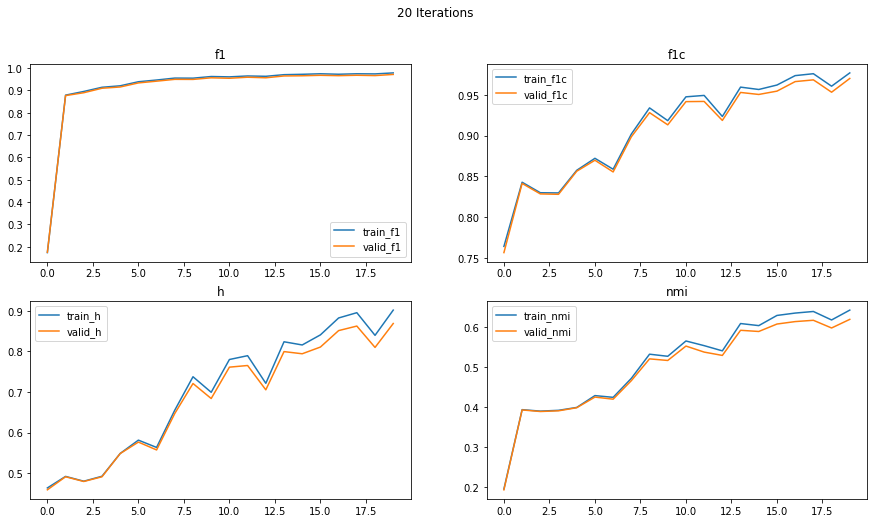

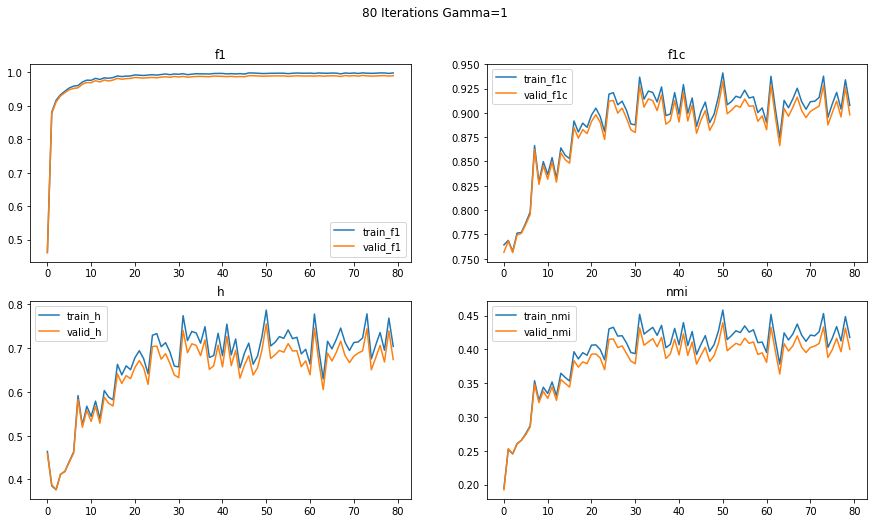

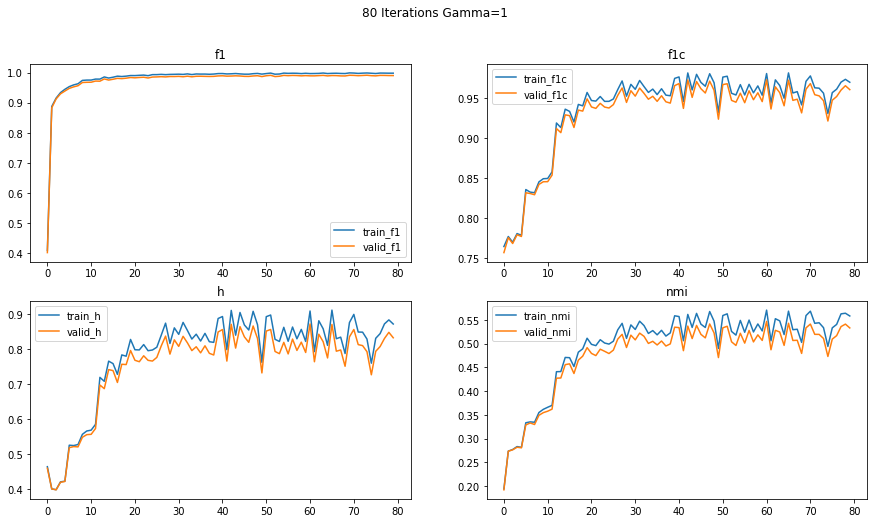

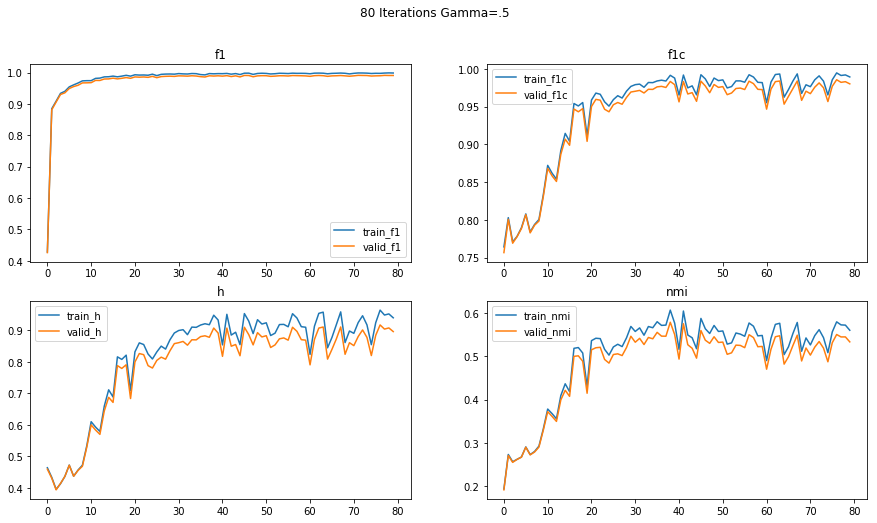

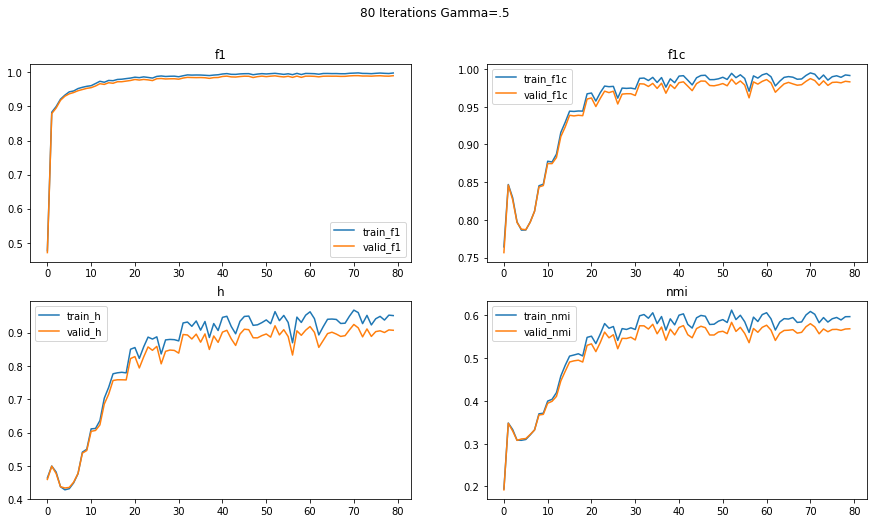

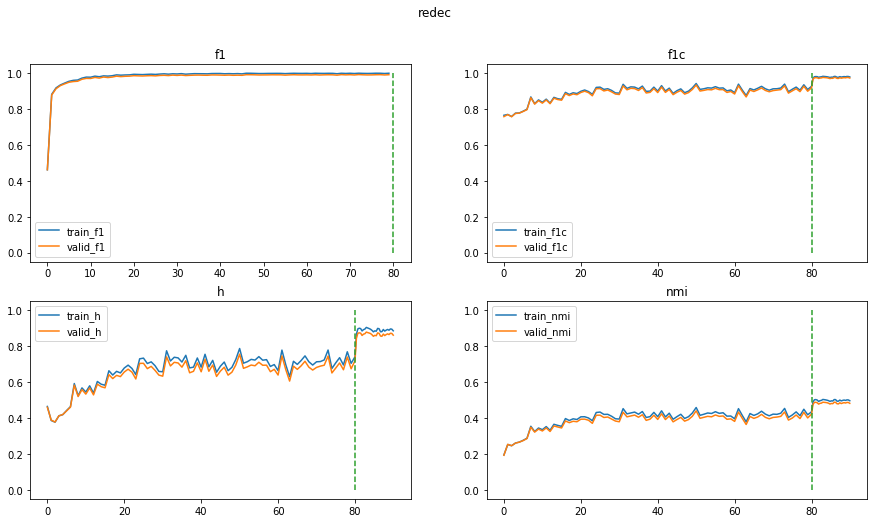

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,20 Iterations,20.000000,0.978395,0.976840,0.901262,0.643121,0.971553,0.970043,0.868307,0.619892
1,80 Iterations Gamma=1,80.000000,0.998163,0.907641,0.703590,0.417669,0.989910,0.898007,0.673644,0.400105
2,80 Iterations Gamma=1,80.000000,0.997810,0.970219,0.871511,0.558021,0.989871,0.960969,0.832188,0.532859
3,80 Iterations Gamma=.5,80.000000,0.998539,0.989160,0.940344,0.559435,0.990679,0.980005,0.896537,0.532711
4,80 Iterations Gamma=.5,80.000000,0.998315,0.991486,0.950881,0.596920,0.990339,0.983078,0.906821,0.568545
5,redec,90.947368,NaN,0.977493,0.884859,0.495768,NaN,0.971480,0.860572,0.481379


In [4]:
report_runs([
#     ('mnt/clustering_models/run_multitask_1/results_final.pkl', '10 Iterations'),
#     ('mnt/clustering_models/run_multitask_2/results_final.pkl', '10 Iterations 2'),
    ('mnt/clustering_models/run_multitask_2_2/results_final.pkl', '20 Iterations'),
#     ('mnt/clustering_models/run_multitask_3/results_final.pkl', '20 Iterations Gamma=1'),
    ('mnt/clustering_models/run_multitask_4_1/results_final.pkl', '80 Iterations Gamma=1'),
#     ('mnt/clustering_models/run_multitask_5_1/results_final.pkl', '80 Iterations Gamma=.5'),
    ('mnt/clustering_models/run_multitask_4/metrics_intermediate.pkl', '80 Iterations Gamma=1'),
    ('mnt/clustering_models/run_multitask_5/metrics_intermediate.pkl', '80 Iterations Gamma=.5'),
    ('mnt/clustering_models/run_multitask_6/metrics_intermediate.pkl', '80 Iterations Gamma=.5'),
    ('mnt/clustering_models/run_multitask_4_1/run_redec_1/metrics_intermediate.pkl', 'redec')
#     ('mnt/clustering_models/run_multitask_7/metrics_intermediate.pkl', '80 Iterations Gamma=.5')
])

Took the second model from above and ran the reclustering step on it. The model tries to move the clusters around given the new embedding learned in the multitask step. The figure below shows the training metrics of both the multitask step and the reclustering step. The green dotted line shows when the reclustering step was started.

### PCA Analysis
Will generate some pca plots of the feature space. First cell shows the feature space of the unsupervised clustering + multitask step

Second cell shows the unsupervised clustering + multitask step + reclustering step

These are for the model where the multitask step was run with gamma=1 for 80 epochs

#### Multitask

In [22]:
save_dir = 'mnt/clustering_models/run_multitask_4_1/run_redec_1'
with open(save_dir+'/metrics_intermediate.pkl', 'rb') as f:
    metrics = pickle.load(f)
item = metrics.dump()

print(metrics.metrics[-1])
display(pandas.DataFrame([OrderedDict([(k, item[k][-1]) for k in sorted(metrics.dump())])]))

# metrics, cmap, pca = analyze_multitask(splits, save_dir)

{'iteration': 89.94736842105263, 'vloss': 0.1600599, 'loss': 0.14820002, 'valid': {'f1c': 0.9714801193532718, 'nmi': 0.48137852404417875, 'f1': nan, 'h': 0.8605717354471042}, 'train': {'f1c': 0.9774926104823012, 'nmi': 0.4957683133842424, 'f1': nan, 'h': 0.8848585917499374}}


,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,89.947368,NaN,0.977493,0.884859,0.495768,NaN,0.97148,0.860572,0.481379


[499, 500, 500, 2000, 10]
(56688, 499)
SGD {'momentum': 0.9, 'lr': 0.01}
[ 0  3  4  6  7  9 14 16 24 25 27 31 34 40 42 46 47 48]
[0.37942213 0.13986403 0.09944021]


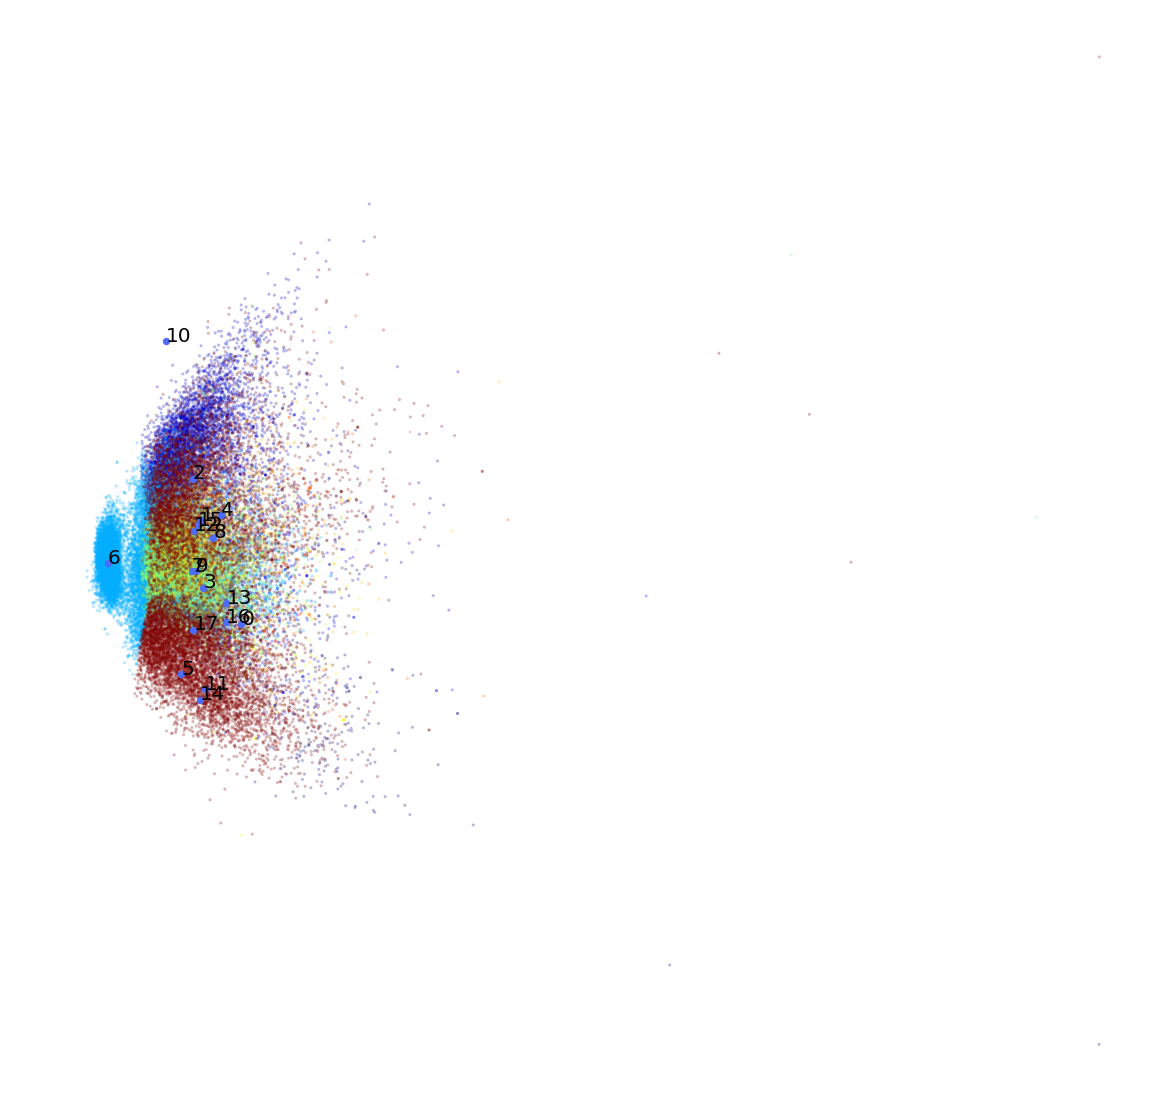

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,79,0.998163,0.907641,0.70359,0.417669,0.98991,0.898007,0.673644,0.400105


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
0,0,332,0.993976
3,0,2328,1.000000
4,0,3349,1.000000
6,0,1259,1.000000
7,0,58,0.982759
9,0,8,1.000000
14,1,22989,0.864022
16,0,7334,1.000000
24,1,2,1.000000
25,0,5376,1.000000


In [18]:
%matplotlib inline
with open('mnt/subjects/tt_split_hugh_xy.pkl', 'rb') as f:
    splits = pickle.load(f)
    
x_test, y_test = splits['test']
x_train, y_train = splits['train']
x_valid, y_valid = splits['valid']
x_train_dev, y_train_dev = splits['train_dev']

save_dir = 'mnt/clustering_models/run_multitask_4_1'

metrics, cmap, pca = analyze_multitask(splits, save_dir)

#### Multitask + Reclustering

[499, 500, 500, 2000, 10]
(56688, 499)
SGD {'momentum': 0.9, 'lr': 0.01}
[ 0  3  4  6  9 14 16 24 25 31 34 46 47 48]
[0.58929396 0.28685215 0.05907239]


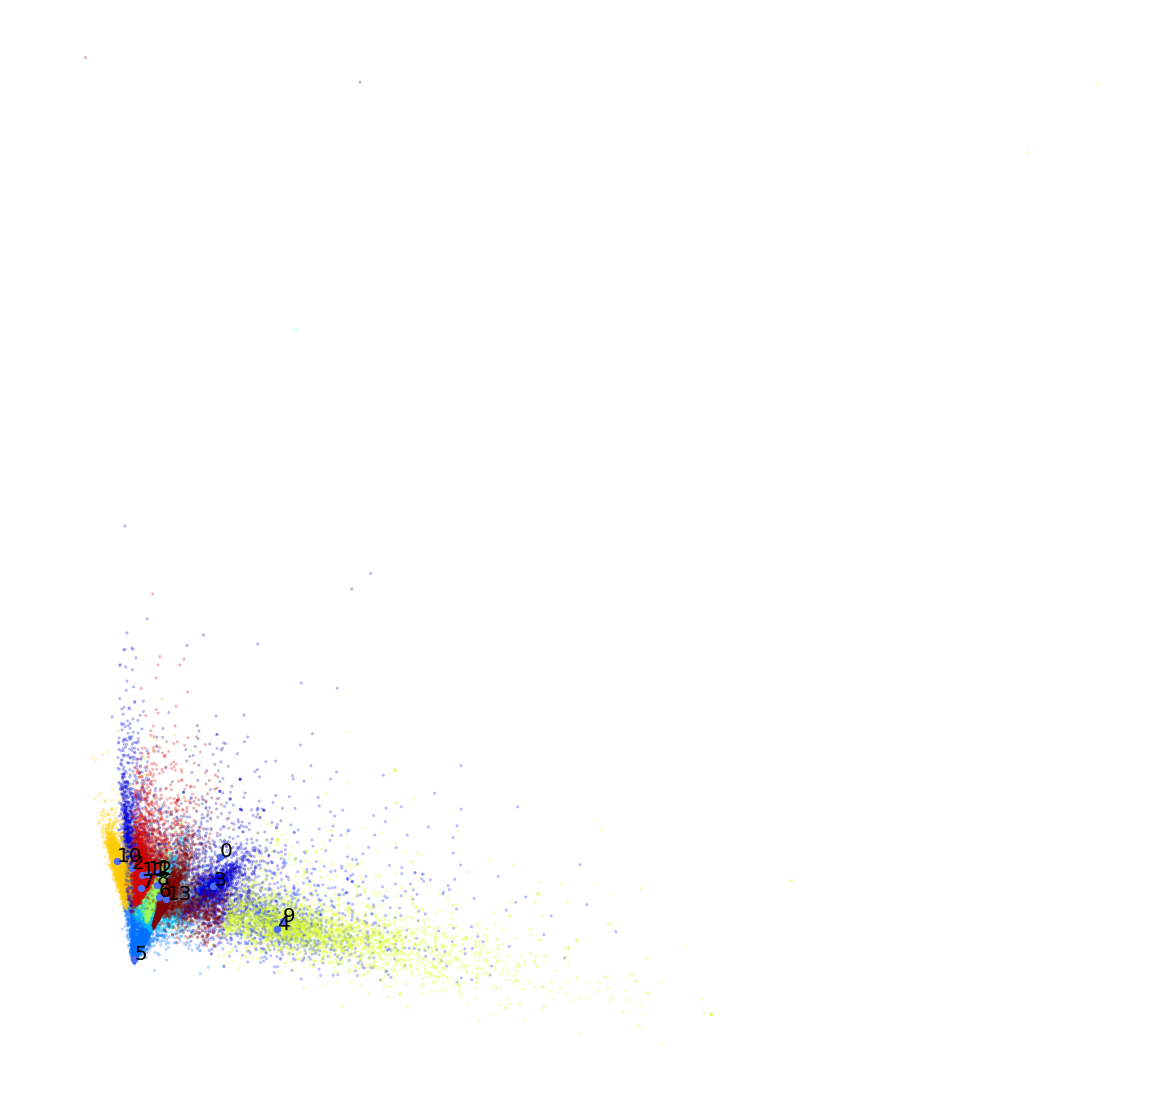

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,89.947368,NaN,0.977493,0.884859,0.495768,NaN,0.97148,0.860572,0.481379


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
0,0,31,0.903226
3,0,1327,1.000000
4,0,6060,0.998350
6,0,3375,0.998815
9,0,1155,0.999134
14,1,20359,0.968613
16,0,4648,0.985585
24,1,1,1.000000
25,0,3912,0.992843
31,0,2976,0.998992


In [26]:
with open('mnt/subjects/tt_split_hugh_xy.pkl', 'rb') as f:
    splits = pickle.load(f)
    
x_test, y_test = splits['test']
x_train, y_train = splits['train']
x_valid, y_valid = splits['valid']
x_train_dev, y_train_dev = splits['train_dev']

save_dir = 'mnt/clustering_models/run_multitask_4_1/run_redec_1'

metrics, cmap, pca = analyze_redec(splits, save_dir)

Figure below shows the final cluster segmentation

In [5]:
cmap = list(zip(*redec.get_cluster_map(x_train, y_train)))
cmap = pandas.DataFrame(cmap, columns=['majority class', 'n_assigned', 'purity'])
display(cmap.loc[cmap['n_assigned']>0])

/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
0,0,31,0.903226
3,0,1327,1.000000
4,0,6060,0.998350
6,0,3375,0.998815
9,0,1155,0.999134
14,1,20359,0.968613
16,0,4648,0.985585
24,1,1,1.000000
25,0,3912,0.992843
31,0,2976,0.998992


## Volunteer Labels

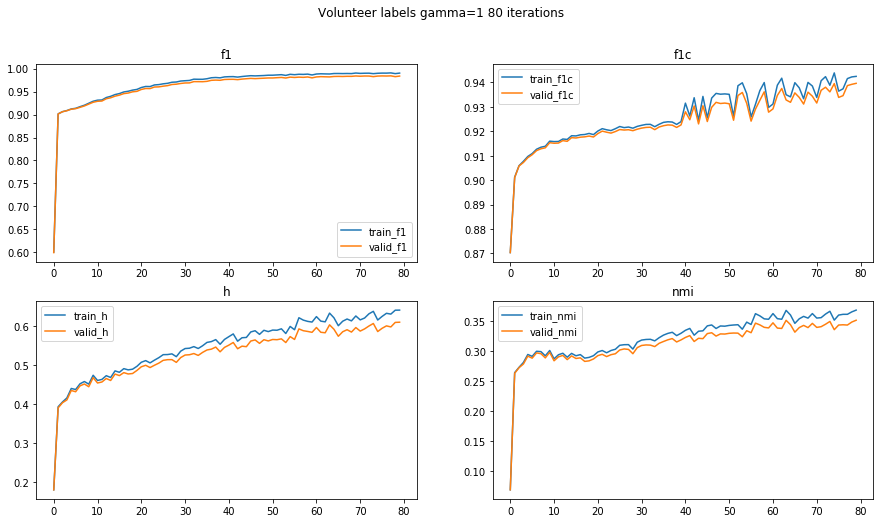

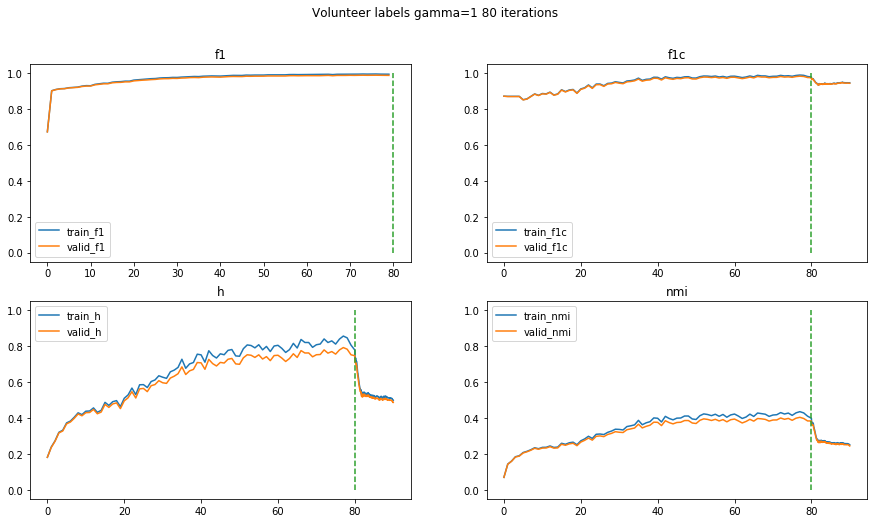

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,Volunteer labels gamma=1 80 iterations,80.000000,0.990208,0.942480,0.641556,0.367579,0.983759,0.939629,0.610575,0.350777
1,Volunteer labels gamma=1 80 iterations,90.988675,NaN,0.944582,0.498316,0.250153,NaN,0.942496,0.486142,0.244393


In [11]:
report_runs([
    ('mnt/clustering_models/run_volunteer_1-1/metrics_intermediate.pkl', 'Volunteer labels gamma=1 80 iterations'),
    ('mnt/clustering_models/aws/run_volunteer_1/run_redec_1/results_final.pkl', 'Volunteer labels gamma=1 80 iterations'),
#     ('mnt/clustering_models/run_volunteer_2/metrics_intermediate.pkl', 'Volunteer labels gamma=.5 80 iterations')
])

#### Multitask step

[499, 500, 500, 2000, 10]
(394638, 499)
SGD {'momentum': 0.9, 'lr': 0.01}
[ 0  4 13 14 16 18 24 31 34 40 42 46 47 49]
[0.38086675 0.12963606 0.11058018]


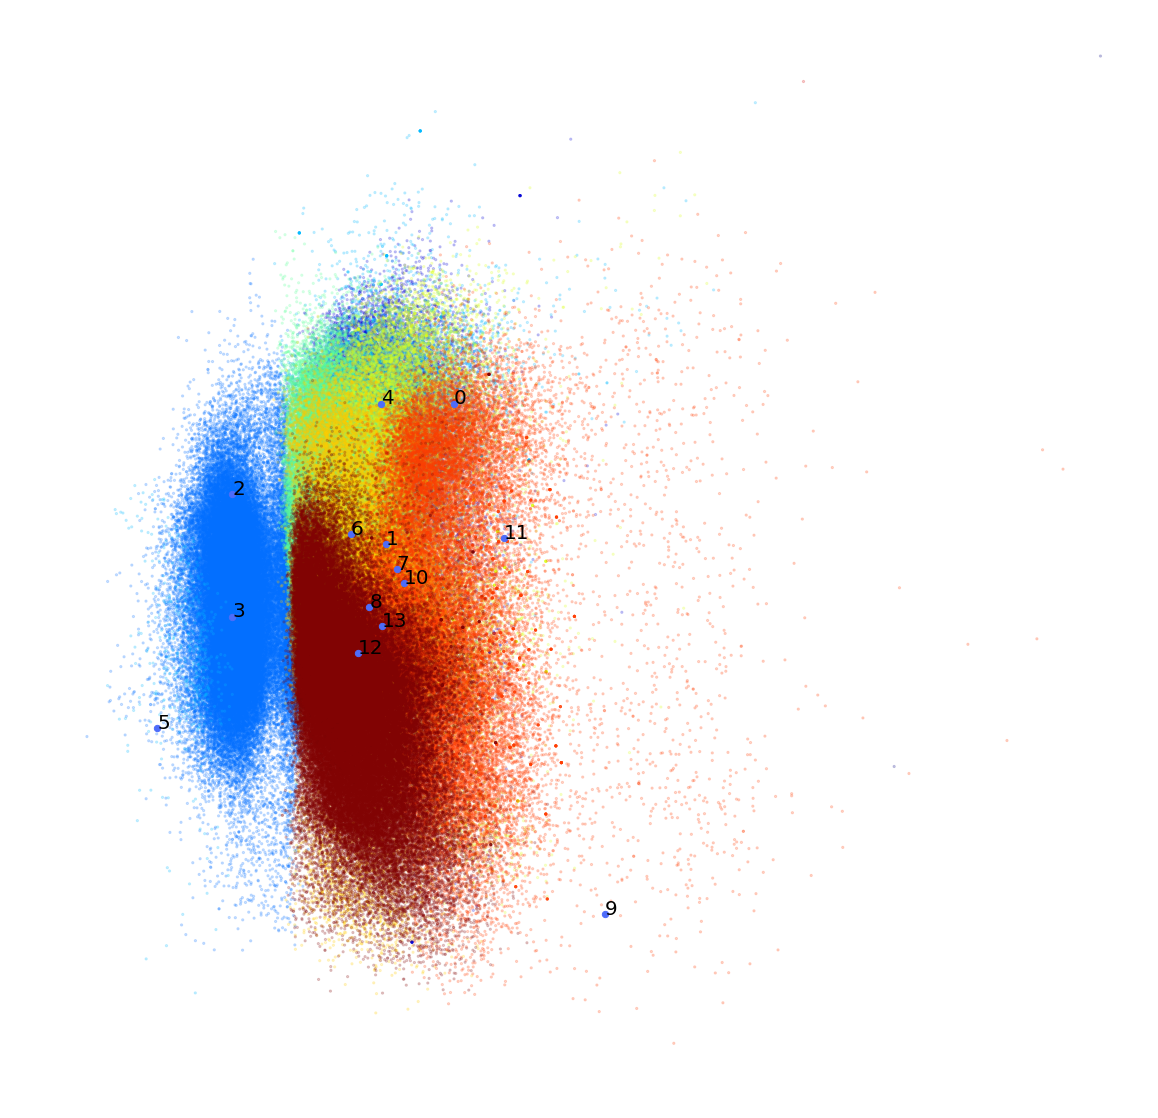

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,89.947368,NaN,0.977493,0.884859,0.495768,NaN,0.97148,0.860572,0.481379


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
0,0,2,1.000000
4,1,30935,0.998642
13,0,1472,0.741168
14,0,98569,0.891944
16,1,9846,0.991265
18,0,467,0.997859
24,1,62165,0.998021
31,1,24078,0.996885
34,1,44759,0.997878
40,0,284,0.996479


In [28]:
with open('mnt/subjects/tt_split_volunteer_majority_all_xy.pkl', 'rb') as f:
    splits = pickle.load(f)
    
x_test, y_test = splits['test']
x_train, y_train = splits['train']
x_valid, y_valid = splits['valid']
x_train_dev, y_train_dev = splits['train_dev']

save_dir = 'mnt/clustering_models/aws/run_volunteer_1'

metrics, cmap, pca = analyze_multitask(splits, save_dir)

[499, 500, 500, 2000, 10]
(394638, 499)
SGD {'momentum': 0.9, 'lr': 0.01}
[ 4 14 16 24 31 34 40 42 47 49]
[0.99194878 0.00516842 0.0016345 ]


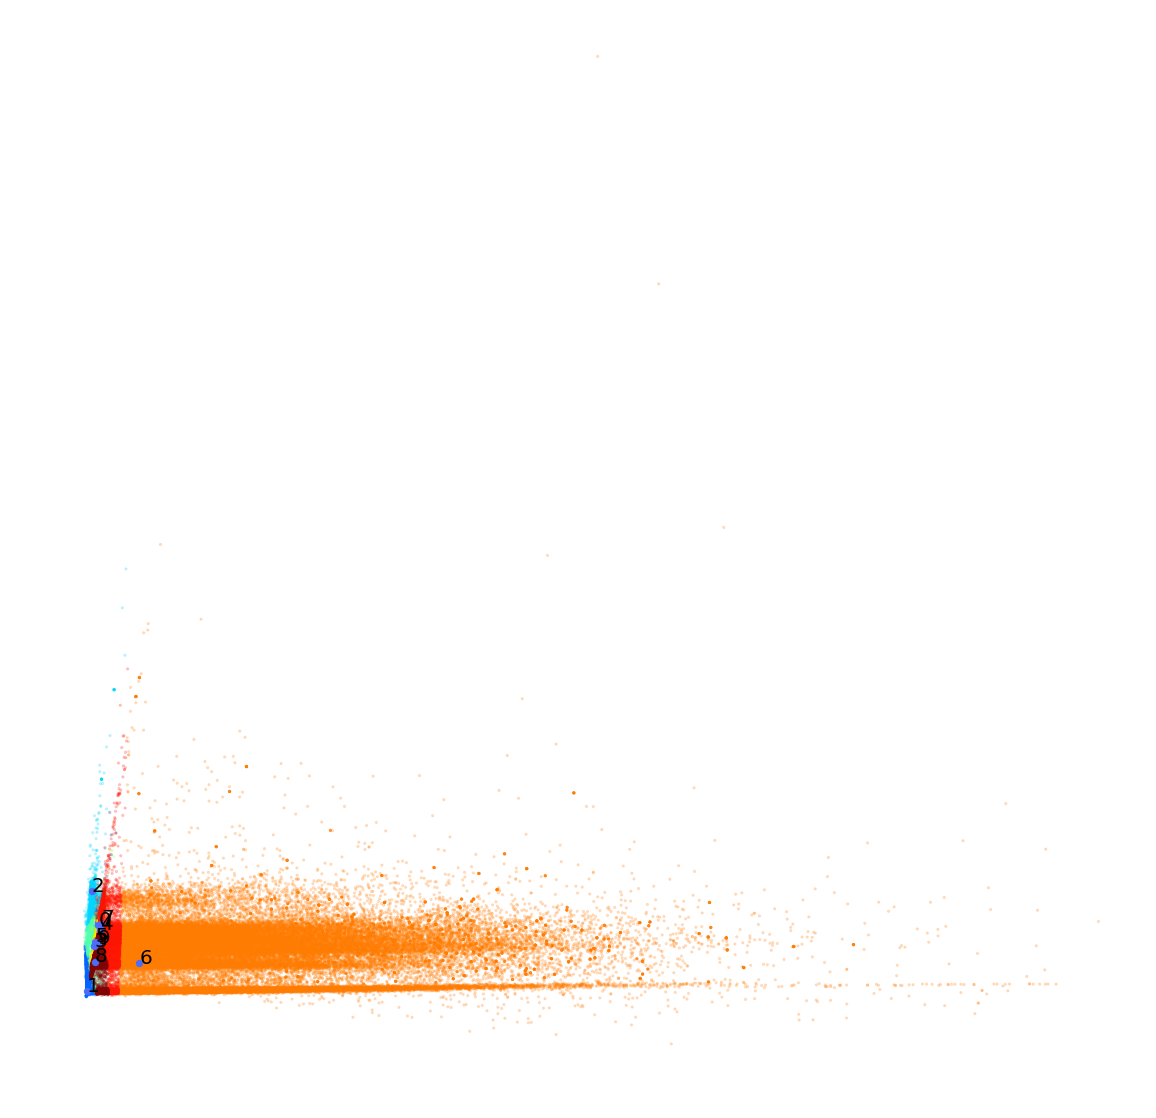

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,89.947368,NaN,0.977493,0.884859,0.495768,NaN,0.97148,0.860572,0.481379


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
4,1,24194,0.971811
14,0,91602,0.818738
16,1,38225,0.968188
24,1,32680,0.932681
31,1,23151,0.971578
34,1,29370,0.965339
40,1,77667,0.920520
42,1,28353,0.949952
47,1,37682,0.947349
49,1,11714,0.940072


In [30]:
with open('mnt/subjects/tt_split_volunteer_majority_all_xy.pkl', 'rb') as f:
    splits = pickle.load(f)
    
x_test, y_test = splits['test']
x_train, y_train = splits['train']
x_valid, y_valid = splits['valid']
x_train_dev, y_train_dev = splits['train_dev']

save_dir = 'mnt/clustering_models/aws/run_volunteer_1/run_redec_1'

metrics, cmap, pca = analyze_redec(splits, save_dir)